In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import time
import tqdm
import math
import random

In [3]:
target_col = 'Class'

In [4]:
df = pd.read_csv('datasets/creditcard/creditcard.csv')

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [22]:
df[target_col].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [23]:
df[target_col].value_counts()/len(df)

0    0.998273
1    0.001727
Name: Class, dtype: float64

# Try different train size and check results

In [8]:
from src.dataset import Dataset

In [9]:
from src.sampling_methods.sampling_methods import RandomSample, XgboostSubsample, TreeSample, CostumeSample, sampling_utils

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(target_col, axis=1), df[target_col], test_size=0.2, shuffle = True)

In [11]:
dataset = Dataset(df, X_train, y_train, X_test, y_test, target_col, f1_score)

### regular methods

In [12]:
random_sample = RandomSample('random')
xgboost_sample = XgboostSubsample('xgb_subsample')
tree_sample = TreeSample('tree')

### imblearn methods

In [13]:
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
from functools import partial

In [14]:
def cluster_sample_function(dataset, p):
    values = list(dataset.y_train.unique())
    cnn = ClusterCentroids(estimator=MiniBatchKMeans(n_clusters=100),
                           sampling_strategy={v: math.ceil(p * len(dataset.y_train[dataset.y_train == v])) for v in values})
    X_real_train, y_real_train = cnn.fit_resample(X_train, y_train)
    return X_real_train, y_real_train

In [15]:
cluster = CostumeSample('cluster', cluster_sample_function)

In [16]:
def cnn_sample_function(dataset, p):
    cnn = CondensedNearestNeighbour()
    X_real_train, y_real_train = cnn.fit_resample(dataset.X_train, dataset.y_train)
    return X_real_train, y_real_train

In [17]:
cnn = CostumeSample('cnn', cnn_sample_function)

## Test

In [18]:
random_sample.test_sample_method(dataset, trials_number=2, print_results=True)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

(0.8351648351648351, 0.558417797088623, 0.04999890276284316)


 17%|██████████████                                                                      | 1/6 [00:01<00:06,  1.27s/it]

(0.8095238095238095, 0.7131662368774414, 0.04999890276284316)
(0.7868852459016393, 1.457763910293579, 0.10000219447431367)


 33%|████████████████████████████                                                        | 2/6 [00:04<00:08,  2.21s/it]

(0.7976190476190476, 1.4088282585144043, 0.10000219447431367)
(0.830409356725146, 3.821223258972168, 0.2)


 50%|██████████████████████████████████████████                                          | 3/6 [00:11<00:14,  4.75s/it]

(0.8295454545454545, 3.952709197998047, 0.2)
(0.8439306358381502, 7.1770851612091064, 0.29999780552568633)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:25<00:16,  8.29s/it]

(0.8555555555555555, 6.522247314453125, 0.29999780552568633)
(0.8187134502923976, 10.193009853363037, 0.4)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:46<00:12, 12.75s/it]

(0.8323699421965318, 10.461915016174316, 0.4)
(0.8488372093023256, 21.990654468536377, 0.7499967082885295)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:31<00:00, 15.18s/it]

(0.8522727272727272, 22.78903555870056, 0.7499967082885295)


In [19]:
xgboost_sample.test_sample_method(dataset, trials_number=2, print_results=True, update_pcts=False)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

(0.8260869565217391, 6.001874208450317)


 17%|██████████████                                                                      | 1/6 [00:12<01:00, 12.10s/it]

(0.7912087912087913, 6.096486330032349)
(0.8275862068965516, 8.941728115081787)


 33%|████████████████████████████                                                        | 2/6 [00:29<01:00, 15.17s/it]

(0.839779005524862, 8.370150089263916)
(0.8160919540229885, 12.634709358215332)


 50%|██████████████████████████████████████████                                          | 3/6 [00:54<00:58, 19.63s/it]

(0.8409090909090909, 12.308761358261108)
(0.8452380952380952, 15.882723569869995)


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:26<00:48, 24.46s/it]

(0.8491620111731844, 15.982412338256836)
(0.8636363636363636, 19.3262357711792)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [02:04<00:29, 29.57s/it]

(0.8636363636363636, 19.308289527893066)
(0.871508379888268, 28.15691614151001)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:01<00:00, 30.18s/it]

(0.8764044943820225, 28.04655647277832)


In [20]:
tree_sample.test_sample_method(dataset, trials_number=2, print_results=True)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

(0.7798742138364779, 11.708677053451538, 0.05091619302596063)


  0%|                                                                                            | 0/6 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
cluster.test_sample_method(dataset, print_results=True, trials_number=2, percents=sampling_utils.DEFAULT_PCT[:1])

C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:66: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(self.pct, self.scores, yerr=self.stds, fmt='bo', color=color, label=self.name, capsize=4)


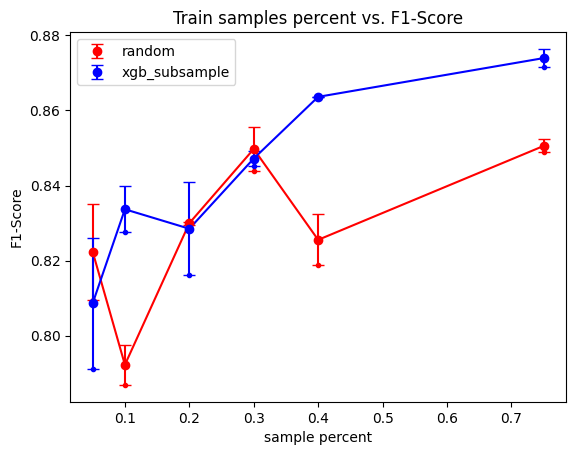

In [21]:
random_sample.print_scores()
xgboost_sample.print_scores('b')
#tree_sample.print_scores('g')
#cluster.print_scores('purple')

plt.title('Train samples percent vs. F1-Score')
plt.xlabel('sample percent')
plt.ylabel('F1-Score')

plt.legend()

C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:74: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(self.pct, self.times, 'bo', color=color, label=self.name)


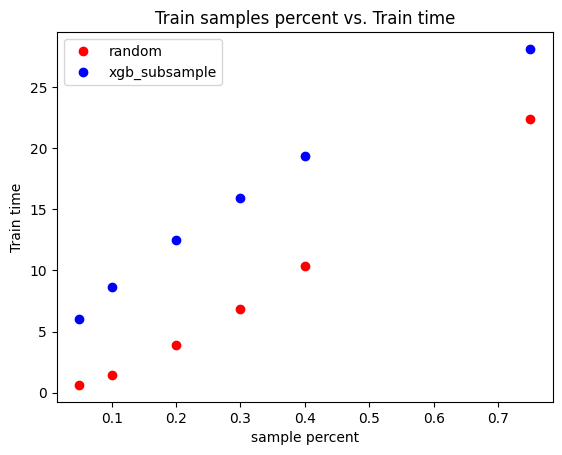

In [22]:
random_sample.print_times()
xgboost_sample.print_times('b')
#tree_sample.print_times('g')
#cluster.print_times('purple')

plt.title('Train samples percent vs. Train time')
plt.xlabel('sample percent')
plt.ylabel('Train time')

plt.legend()

In [ ]:
random_sample.print_times()
xgboost_sample.print_times('b')
tree_sample.print_times('g')

plt.title('Train samples percent vs. Train time')
plt.xlabel('sample percent')
plt.ylabel('Train time')
plt.legend()

## Test small ps

In [ ]:
small_pct = [0.001, 0.003, 0.005, 0.007, 0.01, 0.015, 0.02, 0.05, 0.1]

In [ ]:
random_small = RandomSample('random')
xgboost_small = XgboostSubsample('xgb_subsample')
tree_small = TreeSample('tree')

In [ ]:
cluster_small = CostumeSample('cluster', cluster_sample_function)

In [ ]:
random_small.test_sample_method(dataset, trials_number=2, print_results=True, percents=small_pct)

In [ ]:
xgboost_small.test_sample_method(dataset, trials_number=2, print_results=True, update_pcts=False, percents=small_pct)

In [ ]:
tree_small.test_sample_method(dataset, trials_number=2, print_results=True, percents=small_pct)

In [ ]:
cluster_small.test_sample_method(dataset, print_results=True, trials_number=2, percents=small_pct)

In [ ]:
random_small.print_scores()
xgboost_small.print_scores('b')
tree_small.print_scores('g')
cluster_small.print_scores('purple')

plt.title('Train samples percent vs. F1-Score')
plt.xlabel('sample percent')
plt.ylabel('F1-Score')

plt.legend()

In [ ]:
random_small.print_times()
xgboost_small.print_times('b')
tree_small.print_times('g')
cluster_small.print_times('purple')

plt.title('Train samples percent vs. Train time')
plt.xlabel('sample percent')
plt.ylabel('Train time')

plt.legend()

## Visualize decision tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [26]:
singel_tree_model = DecisionTreeClassifier(min_weight_fraction_leaf=0.05, class_weight='balanced')

In [27]:
s = time.time()
singel_tree_model.fit(X_train, y_train)
time.time() - s

5.771573543548584

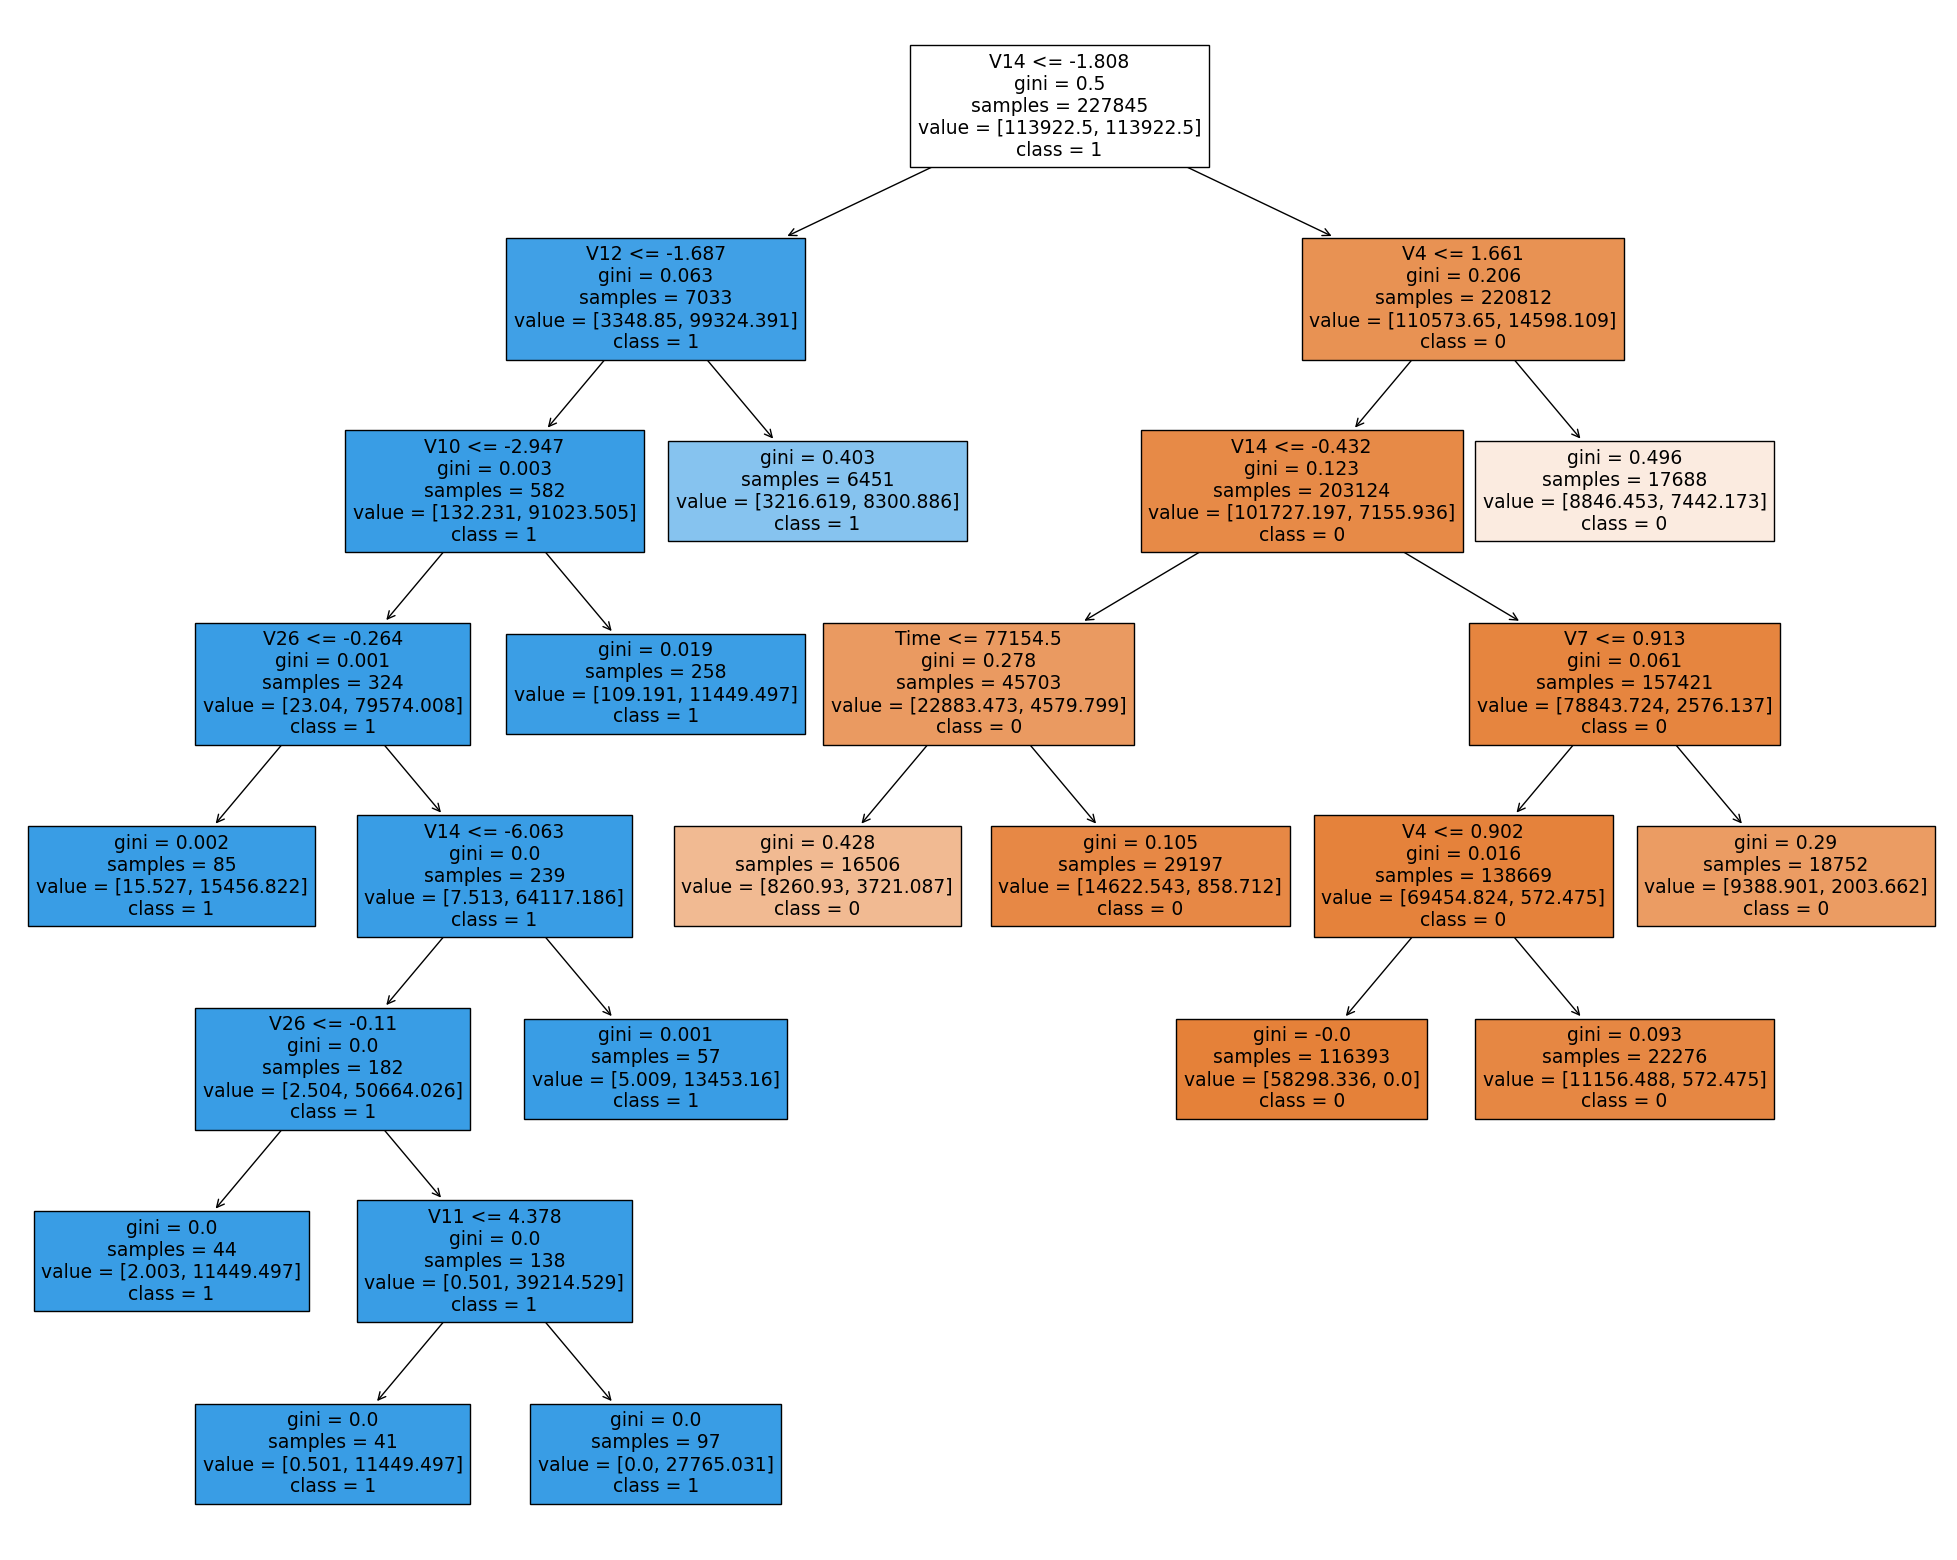

In [28]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(singel_tree_model, 
                   feature_names=X_train.columns,  
                   class_names=['0','1'],
                   filled=True,
                   )

## XGBoost paths

In [12]:
from src.gbdt_model_paths.model_path import ModelPath

In [13]:
model_path = ModelPath(xgb.XGBClassifier(max_depth=3), dataset)

C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.X_diff[f'diff_{n}'] = round(self.X_diff[f'pred_{n}'] - self.X_diff[f'pred_{n - 1}'], 5)
C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.X_diff[f'pred_{n}'] = model.predict(dataset.X_train, iteration_range=(0, n+1), output_margin=True)
C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:16: PerformanceWarnin

### EDA

In [32]:
#for num_trees in range(0, model_path.num_trees, 5):
for num_trees in range(0, 31, 5):
    print(f'trees number: {num_trees}')
    model_path.get_groups_info(model_path.X_diff.groupby([f'diff_{i}' for i in range(num_trees + 1)]))
    print('\n')

trees number: 0


C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:23: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:


1: 1, 0: 0, all: 7
part of groups: 0.14285714285714285
part of examples: 0.00010094581842919528


trees number: 5
1: 37, 0: 36, all: 91
part of groups: 0.8021978021978022
part of examples: 0.0017336347078057452


trees number: 10
1: 131, 0: 143, all: 289
part of groups: 0.9480968858131488
part of examples: 0.004621562904606202


trees number: 15
1: 213, 0: 292, all: 521
part of groups: 0.9692898272552783
part of examples: 0.01006824815115539


trees number: 20
1: 266, 0: 940, all: 1240
part of groups: 0.9725806451612903
part of examples: 0.10202111084289758


trees number: 25
1: 300, 0: 5246, all: 5579
part of groups: 0.9940849614626277
part of examples: 0.9384274397068182


trees number: 30
1: 326, 0: 19283, all: 19628
part of groups: 0.999031995109028
part of examples: 0.998349755316114




(array([2305., 1457.,  490.,   93.]),
 array([   1.,    2.,   10.,  100., 1000.]),
 <BarContainer object of 4 artists>)

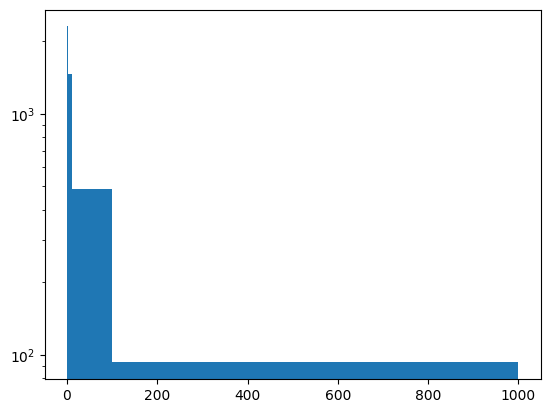

In [34]:
grouped_df = model_path.X_diff.groupby([f'diff_{i}' for i in range(25)]).count()[[target_col]]
plt.hist(grouped_df[target_col], log=True, bins=[1,2,10,100,1000])

In [37]:
ratios, counts = model_path.get_groups_info(model_path.X_diff.groupby([f'diff_{i}' for i in range(26)]), print_stats=False)
sum([counts[i] for i in range(len(ratios)) if counts[i] > 10]) / sum(counts)

0.9561675700585924

In [38]:
ratios, counts = model_path.get_groups_info(model_path.X_diff.groupby([f'diff_{i}' for i in range(26)]), print_stats=False)
sum([counts[i] for i in range(len(ratios)) if counts[i] > 10]) / sum(counts)

0.9561675700585924

(array([4885.,  266.,  104.,   56.,   45.,   25.,   24.,   17.,   15.,
          16.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

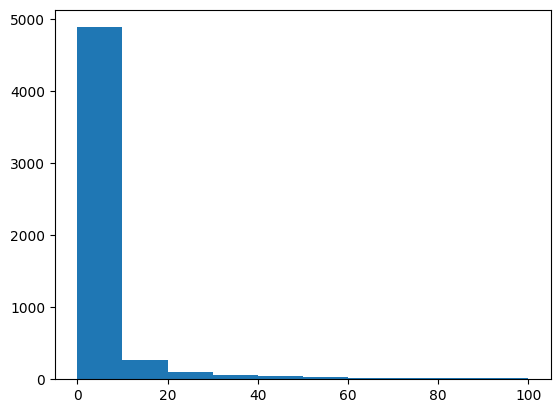

In [39]:
plt.hist(counts, range=(0, 100))

(array([5.264e+03, 1.000e+00, 3.000e+00, 8.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 3.000e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

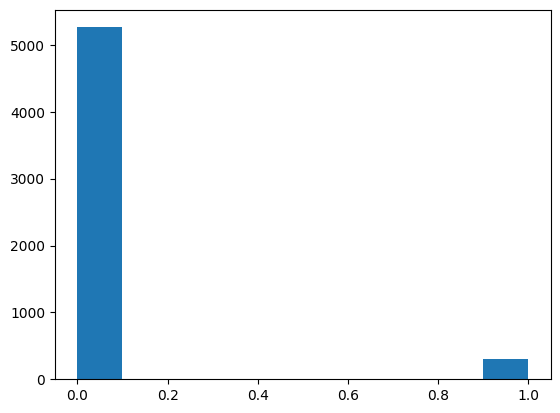

In [40]:
plt.hist(ratios)

In [41]:
sum([counts[i] for i in range(len(ratios)) if counts[i] > 10]) / sum(counts)

0.9561675700585924

In [42]:
len(counts) / sum(counts)

0.02448594439202089

### Sample by leafs combinations

In [19]:
colors = ['g', 'b', 'r', 'c', 'm', 'y', 'k', 'pink'] 

In [14]:
from src.sampling_methods.sampling_methods import XgboostPathSample

In [15]:
experimets = [XgboostPathSample(f'{i} trees', model_path, i) for i in [1, 2, 3, 5, 7, 10, 13, 20]]

In [20]:
for e in experimets:
    print ('#######################################')
    e.test_sample_method(dataset, print_results=True, trials_number=2, percents=sampling_utils.DEFAULT_PCT[:-2])

#######################################


  0%|                                                                                            | 0/4 [00:03<?, ?it/s]

KeyboardInterrupt



C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:66: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(self.pct, self.scores, yerr=self.stds, fmt='bo', color=color, label=self.name, capsize=4)


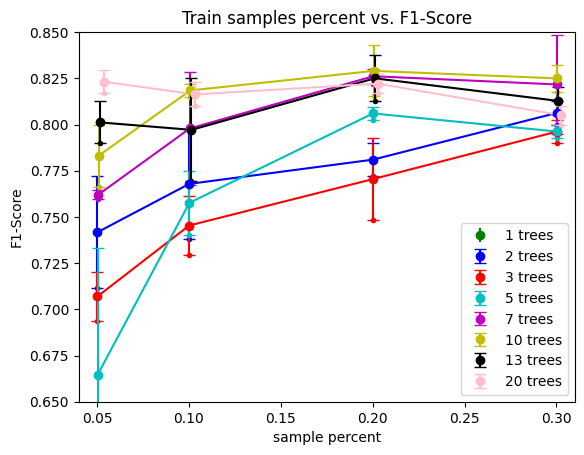

In [21]:
for i, e in enumerate(experimets):
    e.print_scores(colors[i])
#trees20.print_scores('brown')
#cosample.print_scores('orange')
#tree_weight.print_scores('grey')
plt.title('Train samples percent vs. F1-Score')
plt.xlabel('sample percent')
plt.ylabel('F1-Score')
plt.ylim((0.65,0.85))
plt.xlim((0.04,0.31))
plt.legend()

C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:74: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(self.pct, self.times, 'bo', color=color, label=self.name)


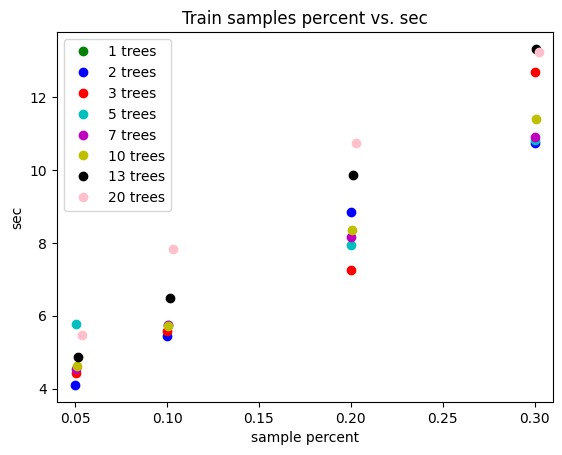

In [24]:
for i, e in enumerate(experimets):
    e.print_times(colors[i])
# trees20.print_times('brown')
# cosample.print_times('orange')
# tree_weight.print_times('grey')
plt.title('Train samples percent vs. sec')
plt.xlabel('sample percent')
plt.ylabel('sec')
plt.xlim((0.04,0.31))
plt.legend()